In [76]:
import matplotlib.pyplot as plt
from imblearn.datasets import make_imbalance
from sklearn.metrics import classification_report
import numpy as np
from scipy.io import arff

from qore_sdk.utils import sliding_window
from qore_sdk.featurizer import Featurizer
from qore_sdk.client import WebQoreClient

from dataloader import load_dataset

import xgboost as xgb
from sklearn.metrics import mean_squared_error

# 取得したアカウント情報の読み込み
from credentials import username, password, endpoint

%matplotlib inline

## データ準備

In [78]:
# sine波の長さ
t_length = 1000
# 分割するときのサイズ
t_width = 400

train_x = np.arange(t_length)
# 平均がsin(x), 分散0.1の正規分布に従う配列を生成
train_y = np.random.normal(np.sin(2 * np.pi * train_x / 100), 0.1)
x = []
y = []
for i in range(len(train_x) - t_width):
    x.append(train_y[i:i + t_width])
    y.append(train_y[i + t_width])

x = np.array(x)
y = np.array(y)

# 学習データとテストデータに分割
X_train = x[0:((t_length - t_width) // 2)]
X_test = x[((t_length - t_width) // 2):]
y_train = y[0:((t_length - t_width) // 2)]
y_test = y[((t_length - t_width) // 2):]

print(X_train.shape)
print(X_test.shape)

(300, 400)
(300, 400)


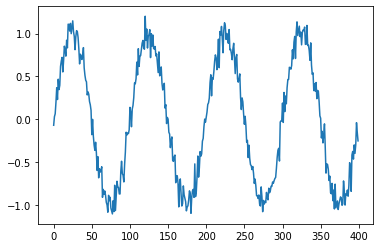

In [79]:
plt.plot(X_train[0])

## 前処理

### Featurizerを使わない場合

In [80]:
X_train = X_train.reshape([300, 400, 1])
X_test = X_test.reshape([300, 400, 1])

### Featurizerを使う場合

In [118]:
# width = 144
# stepsize = 36
# n_filters = 40

# # ここで(サンプル数, 時系列長, 小時系列長)の配列を作成
# X_train = sliding_window(X_train, width, stepsize)
# X_test = sliding_window(X_test, width, stepsize)
# print('X_train.shape:', X_train.shape)
# print('X_test.shape:', X_test.shape)

# # (サンプル数, 時系列長, 変量数)の配列に変換(Qoreへの入力となる)
# featurizer = Featurizer(n_filters)
# X_train = featurizer.featurize(X_train, axis=2)
# X_test = featurizer.featurize(X_test, axis=2)
# print(X_train.shape, X_test.shape)

## 学習

In [109]:
client = WebQoreClient(username, password, endpoint=endpoint)
time_ = client.regression_train(X_train, y_train)
print(time_)

{'res': 'ok', 'train_time': 6.515389919281006}


## 予測と評価

In [110]:
# 予測
res = client.regression_predict(X_test)

0.1262689888187055


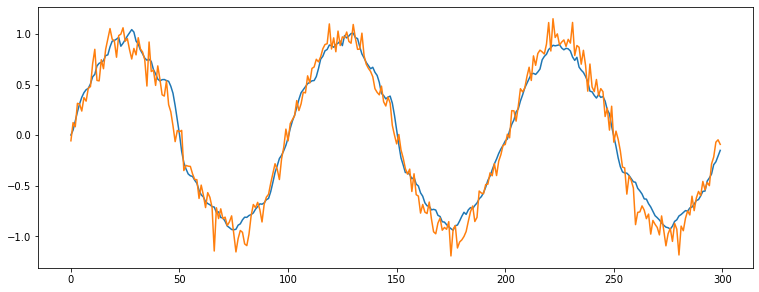

In [111]:
# 評価
plt.plot(res['Y'],  figure=plt.figure(figsize=(12.8, 4.8)))
plt.plot(y_test)

# # 平均平方二乗誤差を求める
rmse = np.sqrt(mean_squared_error(y_test, res['Y']))
print(rmse)

In [101]:
# n個先の時刻の予測を行う
def predict(n):
    data = X_test[-1].reshape(400)
    for i in range(n):
        res = client.regression_predict([data[len(data) - 400:]])
        data = np.append(data, res['Y'][0])
    return data[len(data) - n:]

[-0.15054679 -0.0768742   0.01257491  0.10987747  0.169357    0.23991513
  0.26099598  0.28312707  0.34321058  0.38390625  0.48547661  0.52758753
  0.62146032  0.64928412  0.68283534  0.64439225  0.64444125  0.64660907
  0.68835831  0.73074329  0.80949259  0.85720921  0.87224984  0.85182023
  0.87318373  0.90604484  0.89937365  0.93027449  0.91961241  0.96696556
  0.96499515  0.94874513  0.92339146  0.88811541  0.83176994  0.81591856
  0.7693795   0.67744911  0.60651088  0.58168769  0.49711442  0.47483146
  0.45020175  0.40131342  0.36811739  0.31743896  0.25118506  0.15303087
  0.11480206  0.06972021  0.00674719 -0.10204008 -0.18377078 -0.22089165
 -0.29403913 -0.33858529 -0.36962906 -0.38521323 -0.41556859 -0.40412191
 -0.45068055 -0.47252774 -0.54686582 -0.55428398 -0.59979486 -0.63333023
 -0.6856122  -0.69921011 -0.69539195 -0.73267019 -0.75431621 -0.78603232
 -0.81528354 -0.83662522 -0.8710252  -0.9072119  -0.92053068 -0.91171658
 -0.91593808 -0.88633233 -0.87870371 -0.86747694 -0

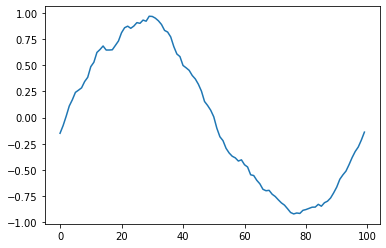

In [113]:
result = predict(100)
print(result)
plt.plot(result)

## GDBT(Gradient Boosting Decision Tree)との比較

In [115]:
# 学習
dtrain = xgb.DMatrix(X_train.reshape(300, 400), label=y_train)
dtest = xgb.DMatrix(X_test.reshape(300, 400))

params = { 'objective': 'reg:squarederror', 'silent': 1, 'random_state': 71 }
num_round = 50
watchlist = [(dtrain, 'train')]
model = xgb.train(params, dtrain, num_round, evals=watchlist)

[0]	train-rmse:0.621822
[1]	train-rmse:0.44353
[2]	train-rmse:0.317761
[3]	train-rmse:0.228667
[4]	train-rmse:0.165879
[5]	train-rmse:0.121141
[6]	train-rmse:0.089298
[7]	train-rmse:0.066471
[8]	train-rmse:0.05008
[9]	train-rmse:0.037717
[10]	train-rmse:0.028895
[11]	train-rmse:0.022462
[12]	train-rmse:0.018045
[13]	train-rmse:0.014371
[14]	train-rmse:0.012031
[15]	train-rmse:0.009749
[16]	train-rmse:0.00838
[17]	train-rmse:0.006909
[18]	train-rmse:0.005725
[19]	train-rmse:0.004946
[20]	train-rmse:0.004277
[21]	train-rmse:0.003803
[22]	train-rmse:0.003333
[23]	train-rmse:0.002911
[24]	train-rmse:0.002697
[25]	train-rmse:0.002499
[26]	train-rmse:0.002345
[27]	train-rmse:0.002215
[28]	train-rmse:0.002081
[29]	train-rmse:0.001964
[30]	train-rmse:0.001874
[31]	train-rmse:0.001753
[32]	train-rmse:0.00163
[33]	train-rmse:0.001506
[34]	train-rmse:0.001385
[35]	train-rmse:0.001289
[36]	train-rmse:0.001234
[37]	train-rmse:0.00118
[38]	train-rmse:0.001126
[39]	train-rmse:0.001051
[40]	train-rmse

In [61]:
# feature importanceの可視化
# fig, ax = plt.subplots(1, 1, figsize=(7, 50))
# xgb.plot_importance(model, ax=ax)

In [116]:
# 予測
pred = model.predict(dtest)

0.12056906199852097


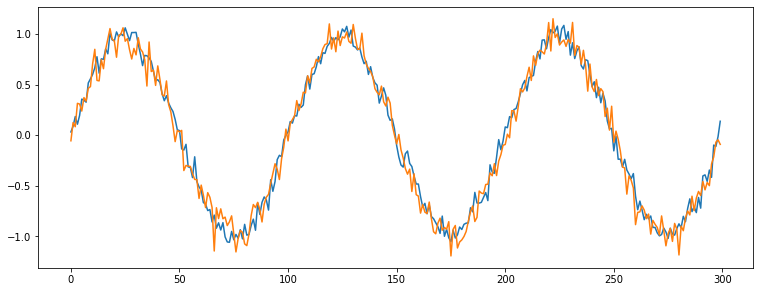

In [117]:
# 評価
plt.plot(pred,  figure=plt.figure(figsize=(12.8, 4.8)))
plt.plot(y_test)

# 平均平方二乗誤差を求める
rmse = np.sqrt(mean_squared_error(y_test, pred))
print(rmse)